# Hyperparameters tuning (Estimators of the NRDD and its transforms)

In [119]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer, RobustScaler, QuantileTransformer, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from scikeras.wrappers import KerasRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

In [74]:
# Load dataframes from binary files
fam = '03'
#base_dir = r'C:\FBr\Weiterbildung\Project'
base_dir = r'D:\Entwicklungen\share\DataScienceProject'
#base_dir = r'D:\FBr\DataScienceProject'

all_data = {}
fam_dir = os.path.join(base_dir, fam, 'data-' + fam)
all_data[fam] = {}

ft_param_path = os.path.join(base_dir, 'Scripts', str(fam) + '-feat-parameters.ft')
df_params = pd.read_feather(ft_param_path)

In [75]:
df_params.head()

,dp_no,dim_x,dim_y,dim_z,nb_slots_x,slot_x_length,slot_x_distance,nb_slots_z,slot_z_length,slot_z_distance,...,disp_long_396,disp_long_397,disp_long_398,disp_long_399,sum_sensi,coupling_long,slot_2-2,slot_3-2,slot_4-1,slot_4-2
0,1001,175.06,121.95,240.31,4,75.993,43.235,2,78.219,59.508,...,0.170716,0.140101,0.144549,0.151599,3.405414e-16,0.960466,0,0,0,1
1,1002,173.45,122.77,238.13,4,81.168,45.859,2,78.924,57.208,...,0.167263,0.146107,0.139493,0.143682,5.401730e-17,0.956635,0,0,0,1
2,1003,175.85,116.71,238.10,4,77.532,45.260,2,80.099,49.215,...,0.293034,0.274524,0.277739,0.284010,2.678586e-18,0.986845,0,0,0,1
3,1004,173.51,116.37,238.30,4,82.428,51.007,2,74.757,50.840,...,0.242726,0.182347,0.183003,0.186770,8.933099e-18,0.967459,0,0,0,1
4,1005,175.60,118.72,241.04,4,76.576,45.981,2,78.773,64.702,...,0.260120,0.259677,0.281911,0.293833,8.025438e-18,0.991598,0,0,0,1


The columns of the DataFrame df_params are listed in the text file df_params_cols.txt

In [76]:
lst_param = df_params.columns.to_list()

# Preparation of the variables

Definition of the explanatory variables (geometrical parameters)

In [77]:
# Unscaled explanatory variables
lst_slot_class = lst_param[541:545]
lst_expl = lst_param[1:4] + lst_param[5:7] + lst_param[8:24] + lst_param[32:34]
X = df_params[lst_expl + lst_slot_class]

In [78]:
# Scale all explanatory variables, except the slot class encoded columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[lst_expl])
X_scaled = pd.concat([pd.DataFrame(X_scaled, columns=lst_expl, index=X.index), X[lst_slot_class]], axis=1)
X_scaled

,dim_x,dim_y,dim_z,slot_x_length,slot_x_distance,slot_z_length,slot_z_distance,chamfer_x_dim_y,chamfer_x_dim_z,chamfer_y_dim_x,...,cut_x_depth,cut_z_start,cut_z_end,cut_z_depth,seg_x_out,seg_z_out,slot_2-2,slot_3-2,slot_4-1,slot_4-2
0,0.052038,0.675477,0.268415,-0.964606,-1.216650,-0.108340,-0.428067,0.972486,0.351407,-1.234165,...,-1.180056,-0.998197,1.186053,-0.393300,-0.288377,-0.617930,0,0,0,1
1,-1.341835,0.959596,-1.619352,1.026687,-0.996598,0.162988,-0.592297,0.290194,-0.021012,1.042796,...,1.632010,-0.762137,-0.141535,1.592878,-0.623407,-0.590973,0,0,0,1
2,0.735987,-1.140108,-1.645330,-0.372413,-1.046831,0.615201,-1.163032,-1.319075,-0.011177,-0.651763,...,-0.942469,-1.417812,-0.872893,-1.224991,-0.564514,-0.184940,0,0,0,1
3,-1.289889,-1.257914,-1.472140,1.511524,-0.564882,-1.440733,-1.047000,0.358075,0.484408,-1.216083,...,1.141323,0.676109,0.111121,-1.076670,-1.132485,-0.339844,0,0,0,1
4,0.519548,-0.443672,0.900556,-0.740273,-0.986367,0.104873,-0.057193,1.012866,0.168618,1.111047,...,-1.348848,-0.708940,-0.831592,-1.280280,-0.538616,-0.799752,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7985,0.155929,-0.173413,-0.407025,-0.071506,1.944072,-0.562863,-0.783161,0.487223,-1.644638,0.338918,...,-1.162380,-0.310659,1.307600,1.497900,1.311448,-0.418957,1,0,0,0
7986,1.099606,-0.939147,0.510880,-0.218112,1.176576,0.495893,-0.158801,-0.123411,-0.523212,-1.668875,...,-0.729932,0.206345,0.998675,1.617276,1.651811,-0.717983,1,0,0,0
7987,-0.857009,-0.758974,-0.640831,0.731937,2.026256,0.345412,-0.382511,-0.528452,-1.660220,0.379828,...,1.271914,0.909537,0.438064,-1.066910,1.269786,-0.683877,1,0,0,0
7988,-0.337554,-0.173413,-0.510938,-1.405192,1.372308,-1.397244,-0.578444,-0.788036,0.288562,-1.670127,...,0.500178,0.463600,-0.127121,1.730853,1.534690,-0.553233,1,0,0,0


In [79]:
kfold = KFold(n_splits=5, shuffle=True, random_state=55)

# Prediction of the Normalized Relative Displacement Deviation of the output displacement

### Baseline model

In [80]:
# Target variable: NRDD
target = 'long_disp_nrdd'
y = df_params[[target]]

In [81]:
num_expl = X.shape[1]
num_expl

27

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state=55)

In [83]:
def baseline_model():

    model = Sequential()
    model.add(Dense(num_expl, input_shape=(num_expl,), kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(loss='mse', optimizer=tf.optimizers.Adam(learning_rate=0.1))

    return model

#model.summary()

KerasRegressor uses the r2_score by default

In [84]:
estimator = KerasRegressor(model=baseline_model, epochs=100, batch_size=32, verbose=0)
scores = cross_val_score(estimator, X_train, y_train, cv=kfold)
print ('Score mean R²:', scores.mean())
print ('Score standard deviation R²:', scores.std())

Score mean R²: 0.5871465853703315
Score standard deviation R²: 0.04178463438129598


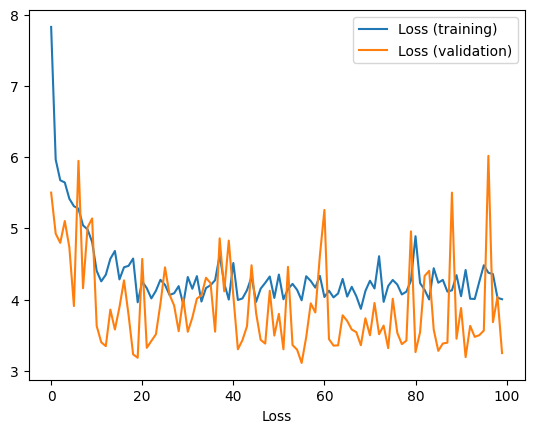

50/50 [==============================] - 0s 835us/step
Score R²: 0.5169326088463175


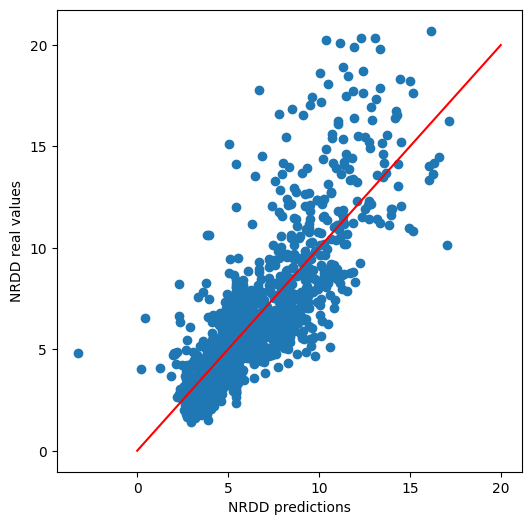

In [85]:
model = baseline_model()
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2)

plt.plot(history.history['loss'], label='Loss (training)')
plt.plot(history.history['val_loss'], label='Loss (validation)')
plt.xlabel('Epochs')
plt.xlabel('Loss')
plt.legend()
plt.show()

y_pred = model.predict(X_test)
print ('Score R²:', r2_score(y_pred, y_test))

fig = plt.figure(figsize=(6, 6))
plt.scatter(y_pred, y_test)
plt.plot([0, 20], [0, 20], color='r')
plt.xlabel('NRDD predictions')
plt.ylabel('NRDD real values')
plt.show()

### Modeling the standardized dataset with a pipeline and perform some transformations to the target variable

In [86]:
preprocessor = ColumnTransformer(
                        transformers=[
                                ('numerical', StandardScaler(), lst_expl),
                                ('categorical', 'passthrough', lst_slot_class)]                              
                        )

pipe = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('mlp', KerasRegressor(model=baseline_model, epochs=100, batch_size=32, validation_split=0.2, verbose=0))
                    ])
                    

In [87]:
X = df_params[lst_expl + lst_slot_class]
y = df_params[['long_disp_nrdd']]

In [88]:
dict_transfs = {'NoTransformation': FunctionTransformer(lambda y: y),
                'Inverse': FunctionTransformer(lambda y: 1/y),
                'InverseSquare': FunctionTransformer(lambda y: 1/y**2),
                'Logarithm': FunctionTransformer(np.log10),
                'InverseLogarithm': FunctionTransformer(lambda y: 1/np.log10(y)),
                'LogarithmInverse': FunctionTransformer(lambda y: np.log10(1/y)),
                'StandardScaler': StandardScaler(),
                'PowerTransformer': PowerTransformer(),
                'QuantileTransformer': QuantileTransformer(),
                'RobustScaler': RobustScaler(),
                'RootSquare': FunctionTransformer(lambda y: np.sqrt(y)),
                'InverseRootSquare': FunctionTransformer(lambda y: 1/np.sqrt(y))
            }

results = pd.DataFrame()

for name, transf in dict_transfs.items():

    print ('---------------')
    print ('** Transformation:', name)

    y_transf = transf.fit_transform(y)    
    X_train, X_test, y_train, y_test = train_test_split(X, y_transf, test_size = 0.2, random_state=55)

    scores = cross_val_score(pipe, X_train, y_train, cv=kfold)
    results[name] = pd.DataFrame([scores.mean(), scores.std()], index=['Score Mean', 'Standard Deviation'])

results

---------------
** Transformation: NoTransformation
---------------
** Transformation: Inverse
---------------
** Transformation: InverseSquare
---------------
** Transformation: Logarithm
---------------
** Transformation: InverseLogarithm
---------------
** Transformation: LogarithmInverse
---------------
** Transformation: StandardScaler
---------------
** Transformation: PowerTransformer
---------------
** Transformation: QuantileTransformer
---------------
** Transformation: RobustScaler
---------------
** Transformation: RootSquare
---------------
** Transformation: InverseRootSquare


,NoTransformation,Inverse,InverseSquare,Logarithm,InverseLogarithm,LogarithmInverse,StandardScaler,PowerTransformer,QuantileTransformer,RobustScaler,RootSquare,InverseRootSquare
Score Mean,0.547210,0.043910,-0.029017,0.348694,0.399875,0.086240,0.387195,0.543295,0.528447,0.421101,0.517381,0.103577
Standard Deviation,0.050738,0.149085,0.028013,0.187315,0.017713,0.439386,0.119201,0.055581,0.035256,0.035969,0.023612,0.208901


The Power transformation provides the best score: this transformation makes data more Gaussian-like

### First hyperparameter tuning with the transformed target variable

First the optimal parameters will searched separately with a GridSearch. Then a Bayesian approach will optimize all the parameters simutaneously within the ranges previously found in the GridSearch.

In [105]:
X = df_params[lst_expl + lst_slot_class]
y = df_params[['long_disp_nrdd']]

transf = PowerTransformer()
y_transf = transf.fit_transform(y) 

X_train, X_test, y_train, y_test = train_test_split(X, y_transf, test_size = 0.2, random_state=55)

In [90]:
def tuning_model(init_mode='normal', activation='relu', nb_neurons=num_expl):
    model = Sequential()
    model.add(Dense(nb_neurons, input_shape=(num_expl,), kernel_initializer=init_mode, activation=activation))
    model.add(Dense(1, kernel_initializer=init_mode))
    model.compile(loss='mse', optimizer=tf.optimizers.Adam(learning_rate=0.1))
    return model

preprocessor = ColumnTransformer(
                        transformers=[
                                ('numerical', StandardScaler(), lst_expl),
                                ('categorical', 'passthrough', lst_slot_class)]                              
                        )

pipe_tuning = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('mlp', KerasRegressor(model=tuning_model, epochs=100, batch_size=32, validation_split=0.2, verbose=0))
                    ])

#### Tune the batch size and number of epochs

In [91]:
lst_batch_size = [100, 250, 500, 750, 1000]
lst_epochs = [75, 100, 125, 140, 150, 160]
params = {'mlp__batch_size': lst_batch_size, 'mlp__epochs': lst_epochs}

In [92]:
grid = GridSearchCV(estimator=pipe_tuning, param_grid=params, n_jobs=-1, cv=5)
grid_result = grid.fit(X_train, y_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
parameters = grid_result.cv_results_['params']

for mean, std, parameter in zip(means, stds, parameters):
    print ('%f (%f) with: %r' % (mean, std, parameter))

print ('Best score:', grid_result.best_score_)
print ('Best parameters:', grid_result.best_params_)

0.744290 (0.032510) with: {'mlp__batch_size': 100, 'mlp__epochs': 75}
0.726693 (0.033351) with: {'mlp__batch_size': 100, 'mlp__epochs': 100}
0.723076 (0.050062) with: {'mlp__batch_size': 100, 'mlp__epochs': 125}
0.764941 (0.012305) with: {'mlp__batch_size': 100, 'mlp__epochs': 140}
0.741856 (0.031713) with: {'mlp__batch_size': 100, 'mlp__epochs': 150}
0.738045 (0.017493) with: {'mlp__batch_size': 100, 'mlp__epochs': 160}
0.765933 (0.006625) with: {'mlp__batch_size': 250, 'mlp__epochs': 75}
0.788748 (0.008750) with: {'mlp__batch_size': 250, 'mlp__epochs': 100}
0.787791 (0.022559) with: {'mlp__batch_size': 250, 'mlp__epochs': 125}
0.792658 (0.023068) with: {'mlp__batch_size': 250, 'mlp__epochs': 140}
0.776798 (0.022245) with: {'mlp__batch_size': 250, 'mlp__epochs': 150}
0.771228 (0.017552) with: {'mlp__batch_size': 250, 'mlp__epochs': 160}
0.796425 (0.013401) with: {'mlp__batch_size': 500, 'mlp__epochs': 75}
0.784782 (0.021123) with: {'mlp__batch_size': 500, 'mlp__epochs': 100}
0.789601 

#### Tune the learning rate of the optimizer

In [120]:
def start_tuning_model(init_mode='normal', activation='relu', nb_neurons=num_expl):
    model = Sequential()
    model.add(Dense(nb_neurons, input_shape=(num_expl,), kernel_initializer=init_mode, activation=activation))
    model.add(Dense(1, kernel_initializer=init_mode))
    #model.compile(loss='mse', optimizer=tf.optimizers.Adam(learning_rate=0.1))
    return model

preprocessor = ColumnTransformer(
                        transformers=[
                                ('numerical', StandardScaler(), lst_expl),
                                ('categorical', 'passthrough', lst_slot_class)]                              
                        )

pipe_start_tuning = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('mlp', KerasRegressor(model=start_tuning_model, loss='mse', optimizer='Adam', epochs=100, batch_size=750, validation_split=0.2, verbose=0))
                    ])

In [124]:
lst_learning_rate = np.linspace(-5, 0, 20)
10**lst_learning_rate

array([1.00000000e-05, 1.83298071e-05, 3.35981829e-05, 6.15848211e-05,
       1.12883789e-04, 2.06913808e-04, 3.79269019e-04, 6.95192796e-04,
       1.27427499e-03, 2.33572147e-03, 4.28133240e-03, 7.84759970e-03,
       1.43844989e-02, 2.63665090e-02, 4.83293024e-02, 8.85866790e-02,
       1.62377674e-01, 2.97635144e-01, 5.45559478e-01, 1.00000000e+00])

In [ ]:
lst_learning_rate = np.linspace(-2, 1, 20)
params = {'mlp__optimizer__learning_rate': 10**lst_learning_rate} 

grid = GridSearchCV(estimator=pipe_start_tuning, param_grid=params, n_jobs=-1, cv=5)
grid_result = grid.fit(X_train, y_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
parameters = grid_result.cv_results_['params']

for mean, std, parameter in zip(means, stds, parameters):
    print ('%f (%f) with: %r' % (mean, std, parameter))

print ('Best score:', grid_result.best_score_)
print ('Best parameters:', grid_result.best_params_)

0.785039 (0.023475) with: {'mlp__optimizer__learning_rate': 0.01}
0.795429 (0.022900) with: {'mlp__optimizer__learning_rate': 0.01438449888287663}
0.806517 (0.020346) with: {'mlp__optimizer__learning_rate': 0.0206913808111479}
0.811347 (0.018199) with: {'mlp__optimizer__learning_rate': 0.029763514416313176}
0.820070 (0.014982) with: {'mlp__optimizer__learning_rate': 0.04281332398719394}
0.812375 (0.008325) with: {'mlp__optimizer__learning_rate': 0.06158482110660264}
0.804492 (0.013431) with: {'mlp__optimizer__learning_rate': 0.08858667904100823}
0.791268 (0.012194) with: {'mlp__optimizer__learning_rate': 0.12742749857031335}
0.800238 (0.010817) with: {'mlp__optimizer__learning_rate': 0.18329807108324356}
0.789734 (0.012054) with: {'mlp__optimizer__learning_rate': 0.26366508987303583}
0.783158 (0.029193) with: {'mlp__optimizer__learning_rate': 0.37926901907322497}
0.720408 (0.023052) with: {'mlp__optimizer__learning_rate': 0.5455594781168517}
0.559741 (0.087323) with: {'mlp__optimizer__

It seems that the learning rate does not show any optimum.

### Tune the number of hidden layers

In [132]:
def start_tuning_model(init_mode='normal', activation='relu', nb_neurons=num_expl):
    model = Sequential()
    model.add(Dense(nb_neurons, input_shape=(num_expl,), kernel_initializer=init_mode, activation=activation))
    model.add(Dense(1, kernel_initializer=init_mode))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.04281332398719394))

    return model

preprocessor = ColumnTransformer(
                        transformers=[
                                ('numerical', StandardScaler(), lst_expl),
                                ('categorical', 'passthrough', lst_slot_class)]                              
                        )

pipe_start_tuning = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('mlp', KerasRegressor(model=start_tuning_model, epochs=100, batch_size=750, validation_split=0.2, verbose=0))
                    ])

In [ ]:
lst_nb_neurons = np.arange(15, 35, 1)
params = {'mlp__model__nb_neurons': lst_nb_neurons}

grid = GridSearchCV(estimator=pipe_start_tuning, param_grid=params, n_jobs=-1, cv=5)
grid_result = grid.fit(X_train, y_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
parameters = grid_result.cv_results_['params']

for mean, std, parameter in zip(means, stds, parameters):
    print ('%f (%f) with: %r' % (mean, std, parameter))

print ('Best score:', grid_result.best_score_)
print ('Best parameters:', grid_result.best_params_)

0.802193 (0.010467) with: {'mlp__model__nb_neurons': 15}
0.807903 (0.006189) with: {'mlp__model__nb_neurons': 16}
0.816122 (0.024786) with: {'mlp__model__nb_neurons': 17}
0.817151 (0.016763) with: {'mlp__model__nb_neurons': 18}
0.806753 (0.020409) with: {'mlp__model__nb_neurons': 19}
0.818193 (0.017952) with: {'mlp__model__nb_neurons': 20}
0.815903 (0.022518) with: {'mlp__model__nb_neurons': 21}
0.817712 (0.016877) with: {'mlp__model__nb_neurons': 22}
0.810809 (0.006287) with: {'mlp__model__nb_neurons': 23}
0.814621 (0.016623) with: {'mlp__model__nb_neurons': 24}
0.820560 (0.011340) with: {'mlp__model__nb_neurons': 25}
0.812102 (0.017078) with: {'mlp__model__nb_neurons': 26}
0.815052 (0.016070) with: {'mlp__model__nb_neurons': 27}
0.819149 (0.014650) with: {'mlp__model__nb_neurons': 28}
0.817433 (0.010479) with: {'mlp__model__nb_neurons': 29}
0.817643 (0.014659) with: {'mlp__model__nb_neurons': 30}
0.814836 (0.013544) with: {'mlp__model__nb_neurons': 31}
0.815149 (0.016610) with: {'mlp

#### Tune the weight initialization and the activation function

In [139]:
def start_tuning_model(init_mode='normal', activation='relu'):
    model = Sequential()
    model.add(Dense(25, input_shape=(num_expl,), kernel_initializer=init_mode, activation=activation))
    model.add(Dense(1, kernel_initializer=init_mode))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.04281332398719394))
    
    return model

preprocessor = ColumnTransformer(
                        transformers=[
                                ('numerical', StandardScaler(), lst_expl),
                                ('categorical', 'passthrough', lst_slot_class)]                              
                        )

pipe_start_tuning = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('mlp', KerasRegressor(model=start_tuning_model, epochs=100, batch_size=750, validation_split=0.2, verbose=0))
                    ])

In [141]:
lst_init_mode = ['normal', 'uniform', 'lecun_uniform', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
lst_activation = ['relu', 'softmax', 'softplus', 'softsign', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
#lst_init_mode = ['normal']
#lst_activation = ['relu']
params = {'mlp__model__init_mode': lst_init_mode, 'mlp__model__activation': lst_activation}

grid = GridSearchCV(estimator=pipe_start_tuning, param_grid=params, n_jobs=-1, cv=5)
grid_result = grid.fit(X_train, y_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
parameters = grid_result.cv_results_['params']

for mean, std, parameter in zip(means, stds, parameters):
    print ('%f (%f) with: %r' % (mean, std, parameter))

print ('Best score:', grid_result.best_score_)
print ('Best parameters:', grid_result.best_params_)

0.815531 (0.014507) with: {'mlp__model__activation': 'relu', 'mlp__model__init_mode': 'normal'}
0.825458 (0.011605) with: {'mlp__model__activation': 'relu', 'mlp__model__init_mode': 'uniform'}
0.805615 (0.017654) with: {'mlp__model__activation': 'relu', 'mlp__model__init_mode': 'lecun_uniform'}
-0.000625 (0.000727) with: {'mlp__model__activation': 'relu', 'mlp__model__init_mode': 'zero'}
0.817000 (0.017346) with: {'mlp__model__activation': 'relu', 'mlp__model__init_mode': 'glorot_normal'}
0.809320 (0.014927) with: {'mlp__model__activation': 'relu', 'mlp__model__init_mode': 'glorot_uniform'}
0.800412 (0.021153) with: {'mlp__model__activation': 'relu', 'mlp__model__init_mode': 'he_normal'}
0.802312 (0.021352) with: {'mlp__model__activation': 'relu', 'mlp__model__init_mode': 'he_uniform'}
0.830739 (0.019225) with: {'mlp__model__activation': 'softmax', 'mlp__model__init_mode': 'normal'}
0.831071 (0.015545) with: {'mlp__model__activation': 'softmax', 'mlp__model__init_mode': 'uniform'}
0.82

The best results are obtained the activation functions Sigmoid and HardSigmoid. The weight initialization of zero can be excluded of the next studies.


### Fine tuning

In [161]:
X = df_params[lst_expl + lst_slot_class]
y = df_params[['long_disp_nrdd']]

transf = PowerTransformer()
y_transf = transf.fit_transform(y) 

X_train, X_test, y_train, y_test = train_test_split(X, y_transf, test_size = 0.2, random_state=55)

In [162]:
def start_tuning_model(init_mode='he_normal', activation='softmax', nb_neurons=25, learning_rate=0.04281332398719394):
    model = Sequential()
    model.add(Dense(nb_neurons, input_shape=(num_expl,), kernel_initializer=init_mode, activation=activation))
    model.add(Dense(1, kernel_initializer=init_mode))
    model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))

    return model

preprocessor = ColumnTransformer(
                        transformers=[
                                ('numerical', StandardScaler(), lst_expl),
                                ('categorical', 'passthrough', lst_slot_class)]                              
                        )

pipe_start_tuning = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('mlp', KerasRegressor(model=start_tuning_model, epochs=100, batch_size=750, validation_split=0.2, verbose=0))
                    ])

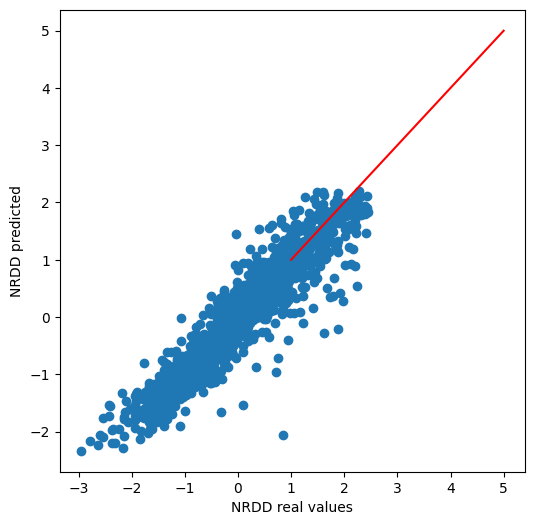

In [163]:
pipe_start_tuning.fit(X_train, y_train)
y_pred_start = pipe_start_tuning.predict(X_test)

fig = plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_start, label='Start neural network')
plt.plot([1, 5], [1, 5], 'r')
plt.xlabel('NRDD real values')
plt.ylabel('NRDD predicted')
plt.show()

In [166]:
params = {'mlp__batch_size': Integer(500, 1000),
          'mlp__epochs': Integer(50, 150),
          'mlp__optimizer__learning_rate': Real(1e-1, 1e1, prior='log-uniform'),
          'mlp__model__init_mode': Categorical(['normal', 'uniform', 'lecun_uniform', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']),
          'mlp__model__activation': Categorical(['sigmoid', 'hard_sigmoid']),
          'mlp__model__nb_neurons': Integer(4, 50)
          }

bayes_search = BayesSearchCV(estimator=pipe_start_tuning,
                                search_spaces=params,
                                n_iter=32,
                                scoring='r2',
                                random_state=55,
                                cv=KFold(n_splits=5, shuffle=True, random_state=55),
                                n_jobs=-1)
bayes_search.fit(X_train, y_train)

BayesSearchCV(cv=KFold(n_splits=5, random_state=55, shuffle=True),
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('numerical',
                                                                          StandardScaler(),
                                                                          ['dim_x',
                                                                           'dim_y',
                                                                           'dim_z',
                                                                           'slot_x_length',
                                                                           'slot_x_distance',
                                                                           'slot_z_length',
                                                                           'slot_z_distance',
                                                                           'chamfer_x_dim_y',
                                                                           'chamfer_x_dim_z',
                                                                           'chamfer_y_dim_x',
                                                                           'chamfer_y_dim_z',
                                                                           'chamfer_z_dim_x'...
                             'mlp__model__activation': Categorical(categories=('sigmoid', 'hard_sigmoid'), prior=None),
                             'mlp__model__init_mode': Categorical(categories=('normal', 'uniform', 'lecun_uniform', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'), prior=None),
                             'mlp__model__nb_neurons': Integer(low=4, high=50, prior='uniform', transform='normalize'),
                             'mlp__optimizer__learning_rate': Real(low=0.1, high=10.0, prior='log-uniform', transform='normalize')})

In [167]:
means = bayes_search.cv_results_['mean_test_score']
stds = bayes_search.cv_results_['std_test_score']
parameters = bayes_search.cv_results_['params']

for mean, std, parameter in zip(means, stds, parameters):
    print ('%f (%f) with: %r' % (mean, std, parameter))

print ('Best score:', bayes_search.best_score_)
print ('Best parameters:', bayes_search.best_params_)

0.804375 (0.009216) with: OrderedDict([('mlp__batch_size', 897), ('mlp__epochs', 126), ('mlp__model__activation', 'hard_sigmoid'), ('mlp__model__init_mode', 'normal'), ('mlp__model__nb_neurons', 17), ('mlp__optimizer__learning_rate', 0.2989137603487479)])
0.777710 (0.006006) with: OrderedDict([('mlp__batch_size', 718), ('mlp__epochs', 59), ('mlp__model__activation', 'hard_sigmoid'), ('mlp__model__init_mode', 'lecun_uniform'), ('mlp__model__nb_neurons', 41), ('mlp__optimizer__learning_rate', 0.7037060655899675)])
0.799621 (0.012894) with: OrderedDict([('mlp__batch_size', 736), ('mlp__epochs', 127), ('mlp__model__activation', 'sigmoid'), ('mlp__model__init_mode', 'he_uniform'), ('mlp__model__nb_neurons', 15), ('mlp__optimizer__learning_rate', 0.13690076088842293)])
0.783109 (0.016482) with: OrderedDict([('mlp__batch_size', 580), ('mlp__epochs', 138), ('mlp__model__activation', 'hard_sigmoid'), ('mlp__model__init_mode', 'uniform'), ('mlp__model__nb_neurons', 15), ('mlp__optimizer__learnin

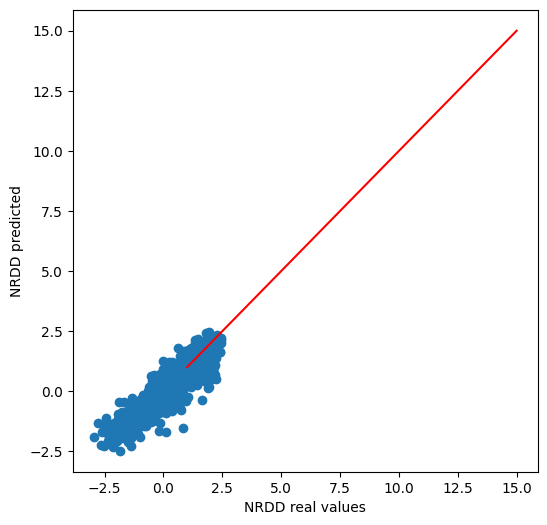

In [169]:
y_transf_pred = bayes_search.predict(X_test)
y_pred = y_transf_pred

fig = plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, label='Tuned neural network')
plt.plot([1, 15], [1, 15], 'r')
plt.xlabel('NRDD real values')
plt.ylabel('NRDD predicted')
plt.show()
